# Kunstformen Neural CA

Based on the [code](https://github.com/google-research/self-organising-systems/blob/master/notebooks/texture_nca_pytorch.ipynb) accompanying the [Self-Organising Textures article](https://distill.pub/selforg/2021/textures/). Code modifications are explained in comments below.

In [1]:
#@title Imports and Notebook Utilities
%tensorflow_version 2.x

import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob

from IPython.display import Image, HTML, clear_output
from tqdm import tqdm_notebook, tnrange

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter


def imread(url, max_size=None, mode=None):
  if url.startswith(('http:', 'https:')):
    r = requests.get(url)
    f = io.BytesIO(r.content)
  else:
    f = url
  img = PIL.Image.open(f)
  if max_size is not None:
    img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  if mode is not None:
    img = img.convert(mode)
  img = np.float32(img)/255.0
  return img

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename='_autoplay.mp4', fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.params['filename'] == '_autoplay.mp4':
      self.show()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))

!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-a6579b69-f85b-2cff-9d60-8c69efeffb25)


In [2]:
import torch
import torchvision.models as models

torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [3]:
#@title VGG16-based Style Model
vgg16 = models.vgg16(pretrained=True).features

def calc_styles(imgs):
  style_layers = [1, 6, 11, 18, 25]  
  mean = torch.tensor([0.485, 0.456, 0.406])[:,None,None]
  std = torch.tensor([0.229, 0.224, 0.225])[:,None,None]
  x = (imgs-mean) / std
  grams = []
  for i, layer in enumerate(vgg16[:max(style_layers)+1]):
    x = layer(x)
    if i in style_layers:
      h, w = x.shape[-2:]
      y = x.clone()  # workaround for pytorch in-place modification bug(?)
      gram = torch.einsum('bchw, bdhw -> bcd', y, y) / (h*w)
      grams.append(gram)
  return grams

def style_loss(grams_x, grams_y):
  loss = 0.0
  for x, y in zip(grams_x, grams_y):
    loss = loss + (x-y).square().mean()
  return loss

def to_nchw(img):
  img = torch.as_tensor(img)
  if len(img.shape) == 3:
    img = img[None,...]
  return img.permute(0, 3, 1, 2)

In [9]:
#@title Minimalistic Neural CA
#@markdown **Modified**: `sobel_x` and `lap` filter kernels were originally divided
#@markdown by 8 and 16 correspondingly, to "equalize" the magnitudes of outputs 
#@markdown of these filters. It seems like removing these dividers makes NCA
#@markdown train faster and better accommodate long-range structures.
ident = torch.tensor([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,0.0]])
sobel_x = torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]]) # /8.0
lap = torch.tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])        # /16.0

def perchannel_conv(x, filters):
  '''filters: [filter_n, h, w]'''
  b, ch, h, w = x.shape
  y = x.reshape(b*ch, 1, h, w)
  y = torch.nn.functional.pad(y, [1, 1, 1, 1], 'circular')
  y = torch.nn.functional.conv2d(y, filters[:,None])
  return y.reshape(b, -1, h, w)

def perception(x):
  filters = torch.stack([ident, sobel_x, sobel_x.T, lap])
  return perchannel_conv(x, filters)

class CA(torch.nn.Module):
  def __init__(self, chn=12, hidden_n=96):
    super().__init__()
    self.chn = chn
    self.w1 = torch.nn.Conv2d(chn*4, hidden_n, 1)
    self.w2 = torch.nn.Conv2d(hidden_n, chn, 1, bias=False)
    self.w2.weight.data.zero_()

  def forward(self, x, update_rate=0.5):
    y = perception(x)
    y = self.w2(torch.relu(self.w1(y)))
    b, c, h, w = y.shape
    udpate_mask = (torch.rand(b, 1, h, w)+update_rate).floor()
    return x+y*udpate_mask

  def seed(self, n, sz=128):
    return torch.zeros(n, self.chn, sz, sz)

def to_rgb(x):
  # Modified: make starting state black
  return x[...,:3,:,:] #+0.5

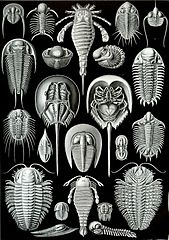

In [14]:
#@title Target image {vertical-output: true}
#@markdown **Modified**: Target image was replaced by the "[Aspidonia](https://commons.wikimedia.org/wiki/File:Haeckel_Aspidonia.jpg)" work by Ernst Haeckel.
style_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/3/31/Haeckel_Aspidonia.jpg/169px-Haeckel_Aspidonia.jpg'
style_img = imread(style_url)#, max_size=128)
with torch.no_grad():
  target_style = calc_styles(to_nchw(style_img))
imshow(style_img)

In [17]:
#@title setup training
#@markdown **Modified**: Training a bit longer, and added another weight decay step
ca = CA() 
opt = torch.optim.Adam(ca.parameters(), 1e-3)
lr_sched = torch.optim.lr_scheduler.MultiStepLR(opt, [2000, 4000], 0.3)
loss_log = []
with torch.no_grad():
  pool = ca.seed(1024)

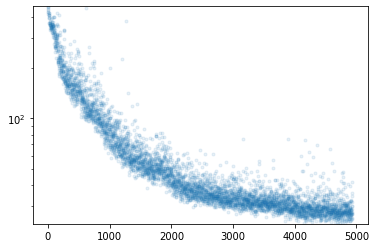

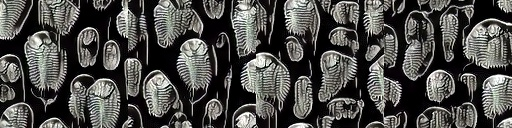

step_n: 5024  loss: 25.46791648864746  lr: 8.999999999999999e-05

In [20]:
#@title training loop {vertical-output: true}
for i in range(5000):
  with torch.no_grad():
    batch_idx = np.random.choice(len(pool), 4, replace=False)
    x = pool[batch_idx]
    # Modified: in the original code the empty state was injected 
    # into every second batch. Turns out that injecting much less often is
    # sufficient to prevent forgetting how to grow from the starting state.
    if i%32 == 0:   
      x[:1] = ca.seed(1)
  step_n = np.random.randint(32, 96)
  for k in range(step_n):
    x = ca(x)
  imgs = to_rgb(x)
  styles = calc_styles(imgs)
  # Modified: calc loss against the avarage gram matrix of the whole batch, 
  # rather than individual images. This should hopefully make CA behaviour more
  # diverse, althought this is a pure unvalidated speculation.
  styles = [g.mean(0) for g in styles]
  loss = style_loss(styles, target_style)
  with torch.no_grad():
    loss.backward()
    for p in ca.parameters():
      p.grad /= (p.grad.norm()+1e-8)   # normalize gradients 
    opt.step()
    opt.zero_grad()
    lr_sched.step()
    pool[batch_idx] = x                # update pool
    
    loss_log.append(loss.item())
    if i%100==0:
      clear_output(True)
      pl.plot(loss_log, '.', alpha=0.1)
      pl.yscale('log')
      pl.ylim(np.min(loss_log), loss_log[0])
      pl.show()
      imgs = to_rgb(x).permute([0, 2, 3, 1]).cpu()
      imshow(np.hstack(imgs))
    if i%10 == 0:
      print('\rstep_n:', len(loss_log),
        ' loss:', loss.item(), 
        ' lr:', lr_sched.get_lr()[0], end='')
    if len(loss_log) % 500 == 0:
      torch.save(ca, 'ca_%05d.pt'%len(loss_log))


In [ ]:
!zip aspidonia.zip *.pt

In [ ]:
#@title NCA video {vertical-output: true}
with VideoWriter() as vid, torch.no_grad():
  x = ca.seed(1, 256)
  for k in tnrange(400, leave=False):
    step_n = min(2**(k//30), 32)
    for i in range(step_n):
      x[:] = ca(x)
    img = to_rgb(x[0]).permute(1, 2, 0).cpu()
    vid.add(zoom(img, 2))